In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from pandas.io.json import json_normalize
import seaborn as sns

from urllib.request import urlopen
import requests
import cv2
from time import time

In [2]:
# read in data from our github repository
dframe = pd.read_json ("https://raw.githubusercontent.com/TiernonRR/Dank_AIT/master/text%20analysis/dank_cleaned.json?token=APDMU6RVFWXJKGVBUQKSBG26W4EA4" )

# checks
print(dframe.shape)
dframe.head()

(38035, 18)


,author,awards,created_utc,text_from_image,words,processed_words,downs,id,is_nsfw,media,subreddit,subscribers,thumbnail.height,thumbnail.thumbnail,thumbnail.width,title,ups,url
1,L71U,[],1584295514,NICE DICK\r\n,Ricardo😎NICE DICK\r\n,"[ricardo, nice, dick]",0,fj5ixk,False,https://i.redd.it/w6acm47gmvm41.jpg,r/dank_meme,743116,136.0,https://b.thumbs.redditmedia.com/PixKjoPWVw738...,140.0,Ricardo😎,35,/r/dank_meme/comments/fj5ixk/ricardo/
2,Awesome-ness5,[],1584294841,Nvidia's calling on gaming PC owners to\r\nput...,Gamers AssembleNvidia's calling on gaming PC o...,"[gamer, assemblenvidia, call, game, owner, sys...",0,fj5bzj,False,https://i.redd.it/bqawbb5gkvm41.jpg,r/dank_meme,743116,140.0,https://b.thumbs.redditmedia.com/Fj8eeEt78J-I6...,140.0,Gamers Assemble,11,/r/dank_meme/comments/fj5bzj/gamers_assemble/
5,None,[],1584293979,JANUARY\r\nFEBRUARY\r\nMARCH\r\nAPRIL\r\ncnu\r...,2020 in a nutshellJANUARY\r\nFEBRUARY\r\nMARCH...,"[nutshelljanuari, februari, march, april, plag...",0,fj53jo,False,https://i.imgur.com/7LmxYnC.png,r/dank_meme,743116,140.0,default,140.0,2020 in a nutshell,1,/r/dank_meme/comments/fj53jo/2020_in_a_nutshell/
7,notaspop,[],1584293653,When you post a low-effort meme\r\nfor fun to ...,I mean.... Not Corona time?When you post a low...,"[mean, corona, time, post, effort, meme, peopl...",0,fj50df,False,https://i.redd.it/v5pea6wwgvm41.jpg,r/dank_meme,743116,140.0,default,140.0,I mean.... Not Corona time?,1,/r/dank_meme/comments/fj50df/i_mean_not_corona...
8,Gaunja420,[],1584293617,H A p pyt1A\r\n,WheNH A p pyt1A\r\n,[whenh],0,fj501g,False,https://i.redd.it/809pja1tgvm41.gif,r/dank_meme,743116,140.0,default,140.0,WheN,1,/r/dank_meme/comments/fj501g/when/


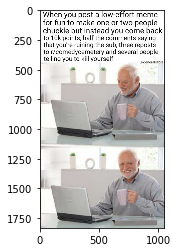

In [3]:
# get an image from media attr to analyze
def url_to_image(url):
    try: 
        request = requests.get(url)
        get_image = urlopen(url)
        arr_image = np.asarray(bytearray(get_image.read()), dtype="uint8") 
        image = cv2.imdecode(arr_image, cv2.IMREAD_COLOR)
    except:
        image = np.array([None,None,None])   
    return image

# check
row = dframe.iloc[3]; test_url = row['media']
im = url_to_image(test_url)
meme1 = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(meme1)
plt.show()

In [4]:
# compute average h s and v components
def average_hsv(meme):
    hsv_meme1 = cv2.cvtColor(meme, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv_meme1)
    return [h.mean(),s.mean(),v.mean()]

# check function
average_hsv(meme1)

[43.803375034797384, 10.925645257791498, 194.97032458170426]

In [5]:
# compute average r g and b components
def average_rgb(meme):
    r, g, b = cv2.split(meme)
    return [r.mean(),g.mean(),b.mean()]

# check function
average_rgb(meme1)

[193.35118716215374, 190.73902739748794, 188.95863006327932]

In [6]:
# colors in hsv
colors_to_mask = []
tan1 = (0, 45, 140)
tan2 = (30, 130, 250)
colors_to_mask.append([tan1,tan2])
light_orange = (1, 190, 200)
dark_orange = (18, 255, 255)
colors_to_mask.append([light_orange,dark_orange])

In [7]:
# function gets data about the amount of one color in image
def getColorMask(meme,color1,color2):
    hsv_meme1 = cv2.cvtColor(meme, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv_meme1, color1, color2)
    result = cv2.bitwise_and(meme, meme, mask=mask)
    return (np.sum(mask)/(meme.shape[0]*meme.shape[1]))

# check
getColorMask(meme1,tan1,tan2)

9.71497565221727

In [14]:
# loop over rows of data frame and gather average r,g,b and h,s,v data
# do this in sections / copy this file and run multiple sections of data simultaneousnessly on different kernel
# takes ~7 minutes to run over 500 records
avg_hsv_list = []; avg_rgb_list = []; color_list = [[],[]]
t0 = time()
for df_row in range(0,dframe.shape[0]):
    row = dframe.iloc[df_row]; url = row['media']
    im = url_to_image(url)
    try:
        meme = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        avg_hsv_list.append(average_hsv(meme))
        avg_rgb_list.append(average_rgb(meme))
        for i in range(0,len(colors_to_mask)):
            color_list[i].append(getColorMask(meme,colors_to_mask[i][0],colors_to_mask[i][1]))
    except:
        avg_hsv_list.append([None,None,None])
        avg_rgb_list.append([None,None,None])
        color_list[0].append(None); color_list[1].append(None); continue
t1 = time()
print('seconds to run: %f' %(t1-t0))

seconds to run: 2312.046676


In [ ]:
# add attributes to data frame
dframe['avg_hue'] = [row[0] for row in avg_hsv_list]
dframe['avg_saturation'] = [row[1] for row in avg_hsv_list]
dframe['avg_value'] = [row[2] for row in avg_hsv_list]
dframe['avg_redRGB'] = [row[0] for row in avg_rgb_list]
dframe['avg_greenRGB'] = [row[1] for row in avg_rgb_list]
dframe['avg_blueRGB'] = [row[2] for row in avg_rgb_list]
dframe['avg_tan'] = color_list[0]
dframe['avg_orange'] = color_list[1]

In [ ]:
# save new data frame to json file
dframe.to_json(r'./dank_cleaned.json')